In [41]:
# Basic Imports
import matplotlib.pyplot as plt
import pandas as pd

# Sci-kit learn imports
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [42]:
# 1 - Load CSV file
abalone = pd.read_csv("abalone.csv")

1 b) The abalone dataset does not require any conversions as none of its features are strings.
The target that we are trying to predict is a string, but not a feature. Therefore, we do not need to convert it. 

In [43]:
# Convert dataset to numpy array and split into features/target
X = abalone.to_numpy()[:, 1:8]
y = abalone.to_numpy()[:, 0]

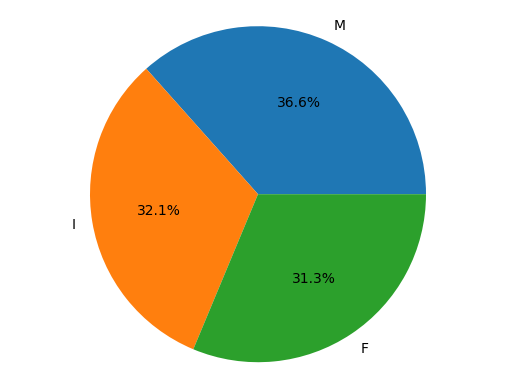

In [45]:
# 2 - Percentages of each output class
labels = 'M', 'I', 'F'
sizes = abalone['Type'].value_counts(normalize=True) * 100

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig1.savefig("abalone-classes")

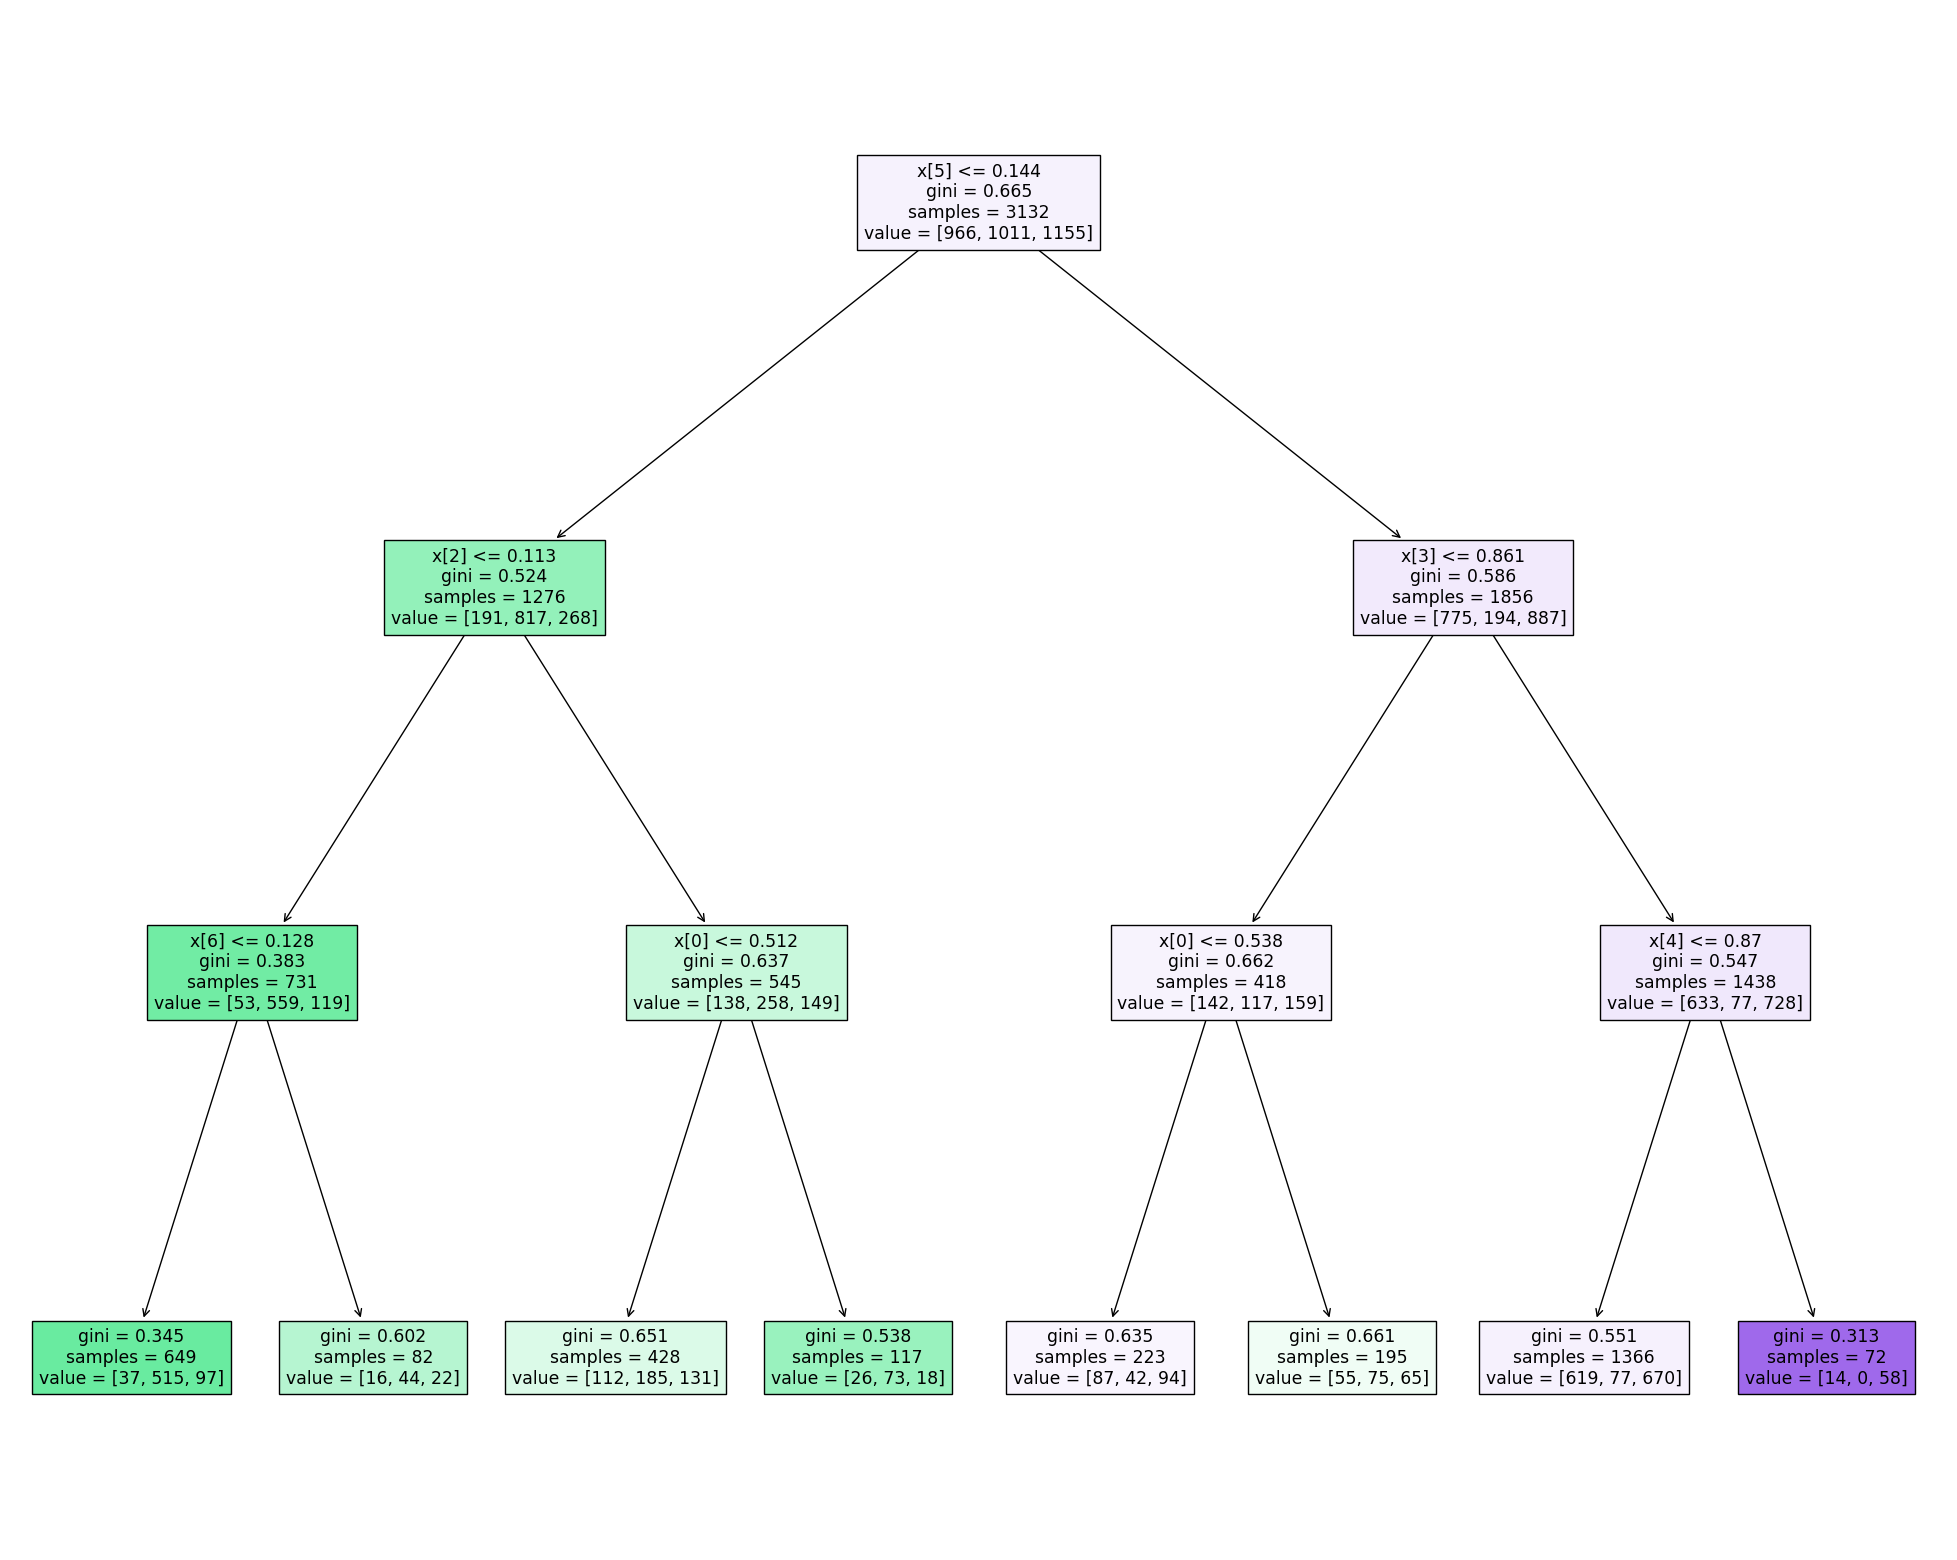

In [46]:
# 3 - Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

dtc = tree.DecisionTreeClassifier(max_depth=3)
dtc.fit(X_train, y_train)

# 4 a) Base DT
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc, filled=True)

In [51]:
# 4 b) Top DT
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,8,None], 'min_samples_split':[2,3,5]}
grid = GridSearchCV(tree.DecisionTreeClassifier(random_state=1), tree_para)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}
0.5565163999164335


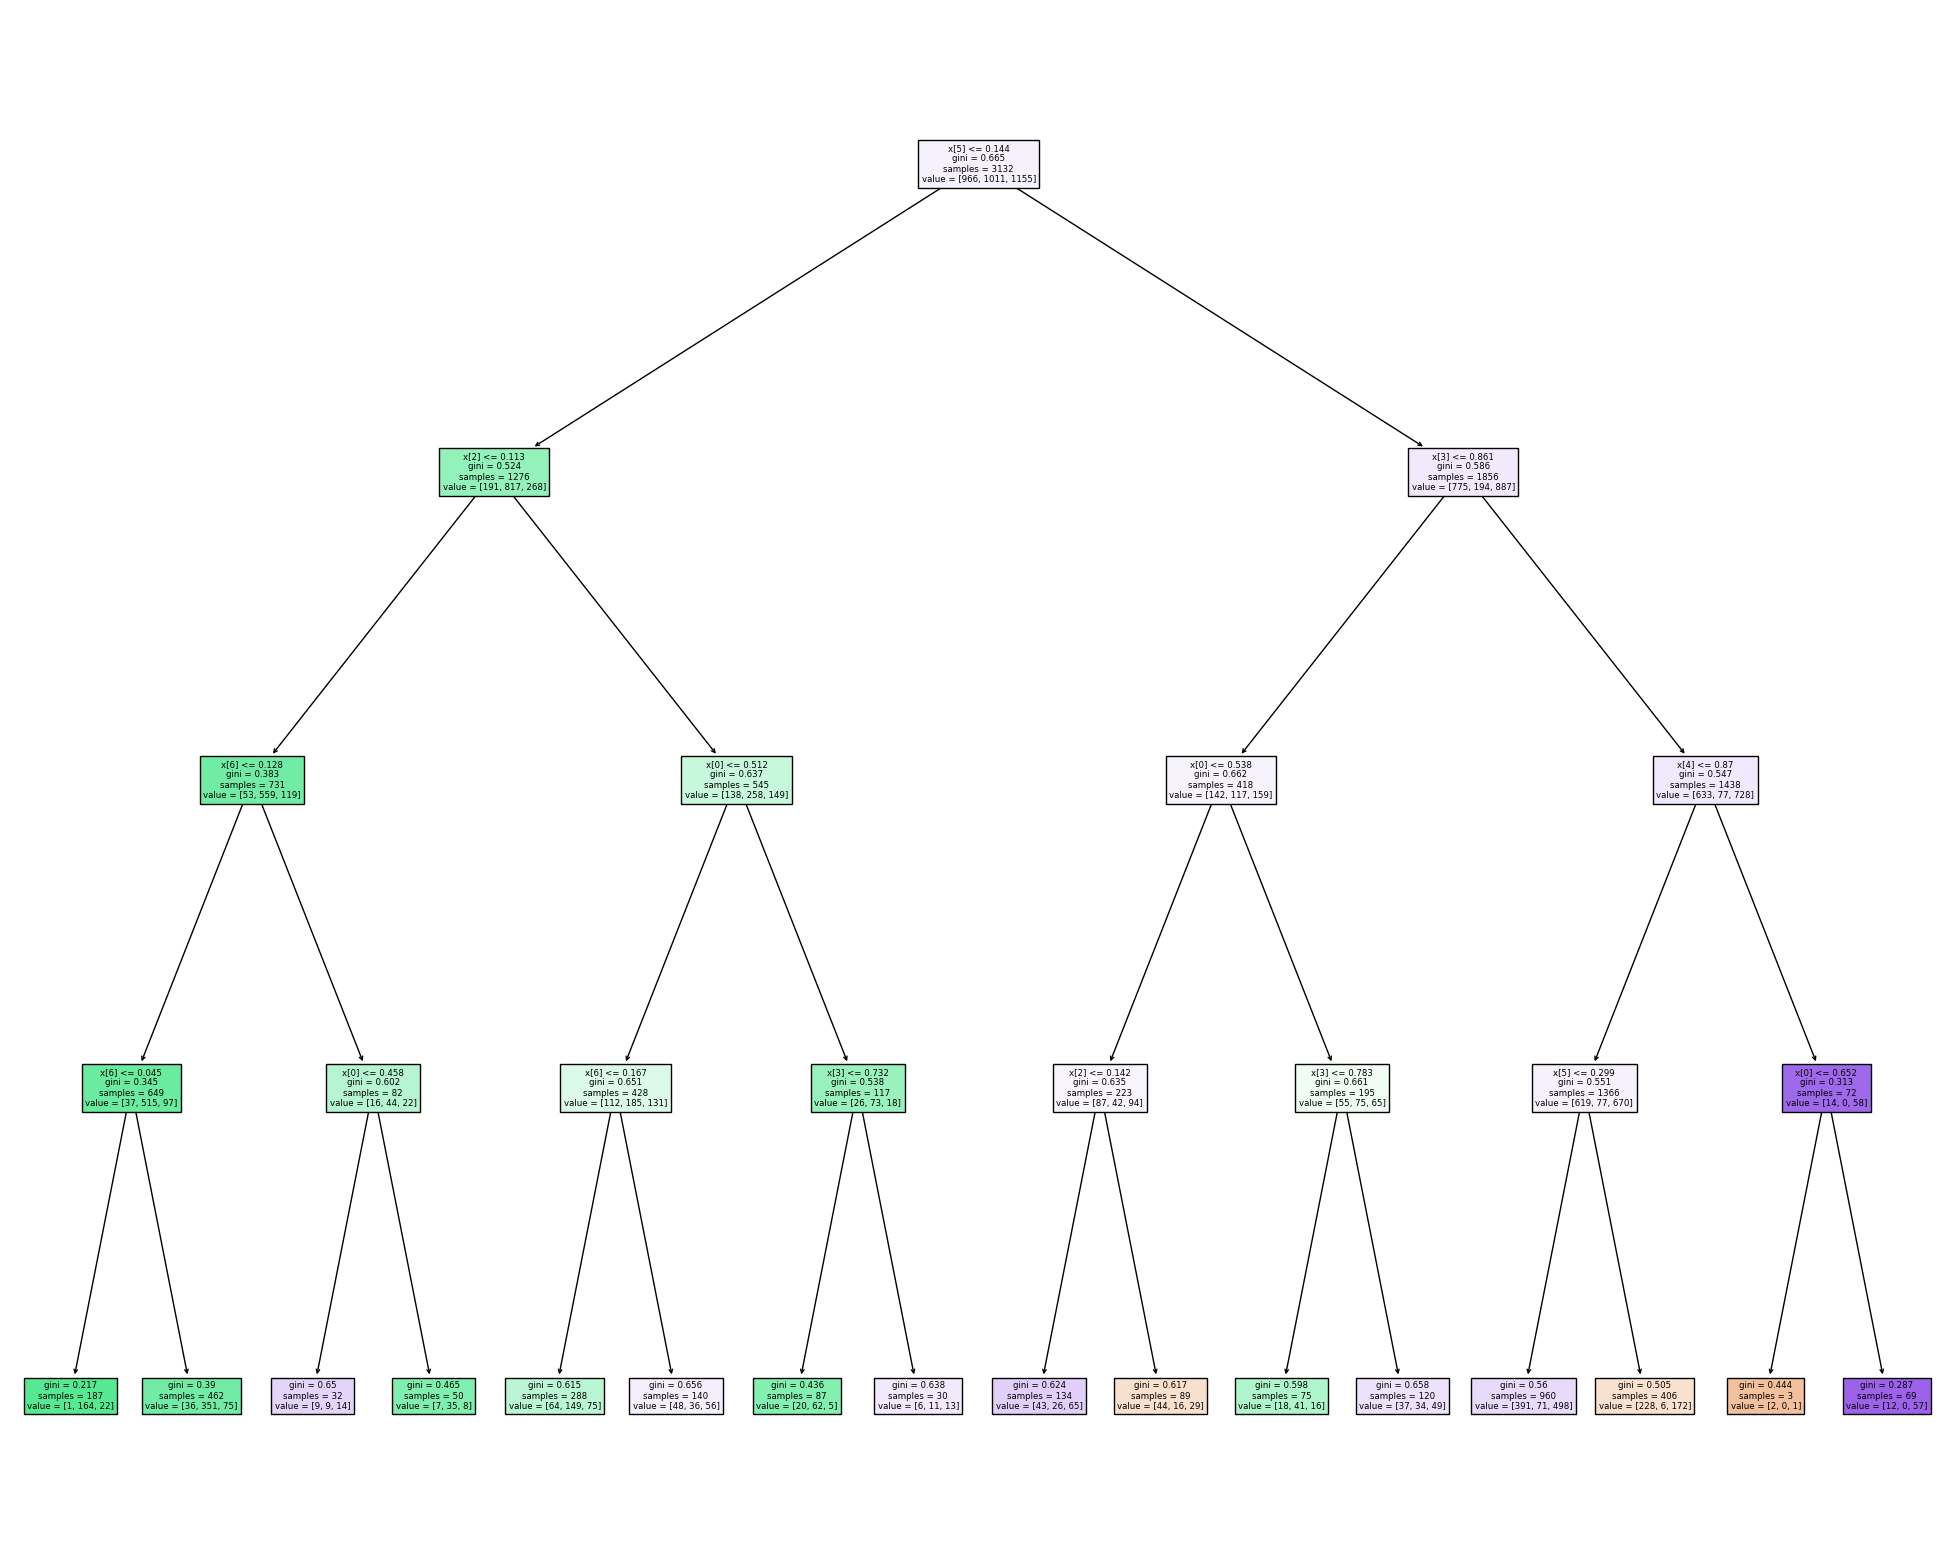

In [52]:
# Plot Top DT
top_dtc = tree.DecisionTreeClassifier(criterion="gini", max_depth=4, min_samples_split=2)
top_dtc.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(top_dtc, filled=True)